# Imports

In [1]:
from gstools import SRF, Gaussian, Exponential, Cubic, Spherical, TPLSimple
import numpy as np
import csv
from random import *
import random
import matplotlib as mpl
import matplotlib.pyplot as plt

# Real Data

### 1) Initialisations

**Import real data:**

In [2]:
def date_correcte(l, date_corr):
    taille = len(l)
    count_point_virgule = 0
    stop = False
    for i in range(taille):
        if l[i] == ";" and not stop:
            count_point_virgule += 1
        if count_point_virgule == 2:
            if l[i+1:i+9] == date_corr:
                return True
            else:
                return False

In [3]:
fichier = open("Real_Data_N-2401.txt", "r")
lignes = fichier.readlines()
fichier.close()

**All Data:**

Domain $S$:

- grid in $[0, 1]^2$

- N points locations (discretization of the spatial domain)

$\Longrightarrow$ points\_S table of points locations of size $(N, 2)$

In [4]:
def creation_domain_S(lignes, date_taille):
    
    N = 0
    ligne_taille = list()
    for ligne in lignes:
        if ligne[0] != "#" and date_correcte(ligne, date_taille):
            N += 1
            ligne_taille.append(ligne)

    Nx = int(np.sqrt(N))
    points_S = np.zeros((N, 2))
    i = 0
    for ligne in ligne_taille:
        points_S[i][0] = float(ligne[:8])
        points_S[i][1] = float(ligne[9:16])
        i += 1
    
    points_S_round = np.zeros((N, 2))
    x_0 = np.round(points_S[1][0], 2)
    y_0 = np.round(points_S[0][1], 2)
    points_S_round[0][0] = x_0
    points_S_round[0][1] = y_0
    for i in range(1, N):
        y_0 = y_0 + 0.1
        if i%Nx == 0:
            x_0 = x_0 + 0.07
            y_0 = np.round(points_S[0][1], 2)
        points_S_round[i][0] = x_0
        points_S_round[i][1] = y_0
    
    return N, Nx, points_S_round

**Sizes:**

- grid scale: $J$

- number of observations for the training step: $n = (1 + 2^J)^2$\
    $\Longrightarrow$ size of dyadic grid of observations ($n_x \times n_x$): $n_x = 1 + 2^J$
    
- total number of points in $S$: $N = N_x^2$\
    $\Longrightarrow$ size of "grid" of all points in $S$: $N_x = \text{step} \times (n_x - 1) + 1$, where step is a strictly positive constant describing the repartition of the observations $X'(\sigma_n)$ on the spatial domain
    
- number of observations for the prediction step: $d$

In [5]:
# DOMAIN S

N, Nx, points_S = creation_domain_S(lignes, "20050701")

J = 4
nx = 1 + 2**J
n = nx**2
step = 3
Nx_2 = step * (nx-1) + 1
N_2 = Nx_2**2
if N == N_2 and Nx == Nx_2:
    print("SIZE OF DOMAINS:\n")
    print("Spatial domain S = [0, 1]^2\n", "Size: N = Nx * Nx = ", Nx, " * ", Nx, " = ", N, "\n")
    print("Dyadic grid at scale J = ", J, "\n", "Size: n = nx * nx = ", nx, " * ", nx, " = ", n, "\n \n \n")
    d = 10
    print("NUMBER OF OBSERVATIONS:\n")
    print("Number of observations for the training step\n n = ", n, "\n")
    print("Number of observations for the prediction step\n d = ", d)

SIZE OF DOMAINS:

Spatial domain S = [0, 1]^2
 Size: N = Nx * Nx =  49  *  49  =  2401 

Dyadic grid at scale J =  4 
 Size: n = nx * nx =  17  *  17  =  289 
 
 

NUMBER OF OBSERVATIONS:

Number of observations for the training step
 n =  289 

Number of observations for the prediction step
 d =  10


**Parameters:**

- parameters of the covariance function for Empirical Kriging: $\theta$ and cov\_type for the type of covariance (Gaussian, Exponential, Cubic, Spherical, TPL)

- parameter for Empirical Kriging: $\nu$

- regularisation parameter for inverse matrix

In [33]:
# PARAMETERS INITIALISATIONS

# Parameter of covariance function for Parametric Kriging
theta = 300
# Type of covariance
cov_type = 5

# Parameter for Non parametric Kriging
nu = 0.35

# Regularisation Parameter
reg = 0.1

### 2) Training Data

Random field for Training step:

$\Longrightarrow$

- vector of observations $X$ used for Kriging: $X'(\sigma_n) = (X'_{\sigma_1}, \cdots, X'_{\sigma_n})$ for training data and $X(s_d) = (X_{s_1}, \cdots, X_{s_d})$ for prediction step

- matrix X\_tot of random field over all the spatial domain $S$

In [7]:
def creation_random_field(N, lignes, date):

    random_field = np.zeros(N)
    i = 0
    for ligne in lignes:
        if ligne[0] != "#" and date_correcte(ligne, date):
            label = float(ligne[40:46])
            random_field[i] = label
            i += 1
    
    return random_field

In [8]:
def creation_training_dataset(n, tot_points, data_train, step):
    
    points_train = np.zeros((n, 2))
    X_train = np.zeros(n)

    points_train[0][0] = tot_points[0][0]
    points_train[0][1] = tot_points[0][1]
    X_train[0] = data_train[0]
    
    N = tot_points.shape[0]
    Nx = int(np.sqrt(N))
    
    stop = False
    count_stop = 0
    j = 1
    for i in range(1, N):
        if i%Nx == 0 and not stop:
            stop = True
            count_stop += 1
        elif i%Nx == 0 and stop and count_stop == step-1:
            stop = False
            count_stop = 0
        elif i%Nx == 0 and stop and count_stop != step-1:
            stop = True
            count_stop += 1
        if i%step == 0 and not stop:
            points_train[j][0] = tot_points[i][0]
            points_train[j][1] = tot_points[i][1]
            X_train[j] = data_train[i]
            j += 1
    return points_train, X_train

### 3) Prediciton Data

In [9]:
def duplicat_sd(tab, a):
    n = tab.shape[0]
    for i in range(n):
        if np.all(tab[i] == a):
            return True
    return False


def creation_testing_dataset(d, tot_points, data_test, seed):
    
    random.seed(seed)

    points_test = np.zeros((d, 2))
    X_test = np.zeros(d)
    
    N = tot_points.shape[0]
    
    for i in range(d):
        ind_rand = randint(0, N-1)
        while duplicat_sd(points_test, tot_points[ind_rand]):
            ind_rand = randint(0, N-1)
        points_test[i] = tot_points[ind_rand]
        X_test[i] = data_test[ind_rand]
    
    return points_test, X_test

### 4) Plotting Field

Generalized function for plotting a field:

- random field (training data or predicition data)

- Kriging result (theoretical or empirical)

- quadratic difference (theoretical or empirical)

- covariance model used for repository

- theta used for file name

In [10]:
def affichage_field(tot_points, field, points_obs, train_or_test, affichage):
     
    N = field.shape[0]
    Nx = int(np.sqrt(N))
     
    field_aff = np.zeros((Nx, Nx))
    k = 0
    l = 0
    for i in range(N):
        field_aff[k][l] = field[i]
        l += 1
        if l == Nx:
            k += 1
            l = 0
            
    if affichage == True:
        
        point_min_x = tot_points[:, 0].min()
        point_max_x = tot_points[:, 0].max()
        point_min_y = tot_points[:, 1].min()
        point_max_y = tot_points[:, 1].max()
        

        
        fig = plt.figure(1, figsize=(6, 5))
        ax = fig.add_subplot(111)
        orig_map=plt.cm.get_cmap('autumn')
        reversed_map = orig_map.reversed()
        plt.imshow(field_aff.T, origin="lower", extent=[point_min_x, point_max_x, point_min_y, point_max_y], cmap = reversed_map)
        
        ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
        
        bound_min = np.round(field.min(), decimals=3)
        bound_max = np.round(field.max(), decimals=3)
        cmap = reversed_map # mpl.cm.viridis
        norm = mpl.colors.Normalize(vmin=bound_min, vmax=bound_max)
        fig.colorbar(
            mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
            extend='both',
            extendfrac='auto',
            spacing='uniform',
        )
        
        if train_or_test == 0:
            color = 'red'
            name_fig = 'Training_Data.png'
        else:
            color = 'cyan' # 'mediumorchid'
            name_fig = 'Testing_Data.png'
        
        #plt.scatter(points_obs[:,0], points_obs[:,1], s=20, c=color, marker='o')
        
        directory = "./RealData/"
        plt.savefig(directory + name_fig)
        plt.show()

    return field_aff


def plotting_field(field, points_obs, bounds_extent, params):
    # params[0]: kriging result, quadratic difference, MSE
    # params[1]: parametric, nonparametric
    fig = plt.figure(1, figsize=(6, 5))
    ax = fig.add_subplot(111)
    plt.imshow(field.T, origin="lower", extent=bounds_extent)
    
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
    plt.scatter(points_obs[:,0], points_obs[:,1], s=40, c='red', marker='o')
    
    # Echelle
    bound_min = np.round(field.min(), decimals=3)
    bound_max = np.round(field.max(), decimals=3)
    cmap = mpl.cm.viridis
    norm = mpl.colors.Normalize(vmin=bound_min, vmax=bound_max)
    fig.colorbar(
        mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
        extend='both',
        extendfrac='auto',
        spacing='uniform',
    )
    
    if params[0] == 0:
        if params[1] == 0:
            title = "Parametric Kriging Result (with observed points)"
            name_fig = "Parametric_Kriging.png"
        else:
            title = "Nonparametric Kriging Result (with observed points)"
            name_fig = "Nonparametric_Kriging.png"
    elif params[0] == 1:
        if params[1] == 0:
            title = "Quadratic Difference for Parametric Kriging (with observed points)"
            name_fig = "Parametric_QD.png"
        else:
            title = "Quadratic Difference for Nonparametric Kriging (with observed points)"
            name_fig = "Nonparametric_QD.png"
    else:
        if params[1] == 0:
            title = "MSE map for Parametric Kriging (with observed points)"
            name_fig = "Parametric_MSE.png"
        else:
            title = "MSE map for Nonparametric Kriging (with observed points)"
            name_fig = "Nonparametric_MSE.png"
            
    plt.title(title)
    
    directory = "./RealData/"
    plt.savefig(directory + name_fig)
    plt.show()

# Parametric Kriging

### Model of covariance

- Gaussian model:
$$c : h \in [0,+\infty) \mapsto \exp\left(-h^2/\theta^2\right)$$

- Exponential model:
$$c : h \in [0,+\infty) \mapsto \exp\left(-h/\theta\right)$$

- Cubic:
$$c : h \in [0,+\infty) \mapsto \left(1 - \left(7 \frac{h^2}{\theta^2} - \frac{35}{4}\frac{h^3}{\theta^3} + \frac{7}{2}\frac{h^5}{\theta^5} - \frac{3}{4}\frac{h^7}{\theta^7}\right) \right)\,\mathbb{I}\left\{h \leq \theta\right\}$$

- Spherical model:
$$c : h \in [0,+\infty) \mapsto \left(1 - \left(\frac{3}{2}\frac{h}{\theta} - \frac{1}{2}\frac{h^3}{\theta^3}\right) \right)\,\mathbb{I}\left\{h \leq \theta\right\}$$

- Truncated Power Law model:
$$c : h \in [0,+\infty) \mapsto \left(1 - h/\theta \right)^{\frac{3}{2}}\,\mathbb{I}\left\{h \leq \theta\right\},$$
where $\theta \in \mathbb{R}_+^*$.

In [11]:
def model_cov_func(h, theta, cov_type):
    if cov_type == 1: # Gaussian
        return np.exp(-(h**2)/(theta**2))
    elif cov_type == 2: # exponential
        return np.exp(-h/theta)
    elif cov_type == 3: # cubic
        if h >= theta:
            return 0
        else:
            return 1 - ( 7*(h/theta)**2 - 8.75*(h/theta)**3 + 3.5*(h/theta)**5 - 0.75*(h/theta)**7 )
    elif cov_type == 4: # spherical
        if h >= theta:
            return 0
        else:
            return 1 - ( 1.5*(h/theta) - 0.5*(h/theta)**3 )
    elif cov_type == 5: # truncated power law
        if h >= theta:
            return 0
        else:
            nu = 1.5
            return (1 - (h/theta))**nu

### Covariance matrix at sampled points

$\Sigma(\mathbf{s}_d)=Var(\mathbf{X}(\mathbf{s}_d)) = (Cov(X_{s_i},X_{s_j}))_{i, j \leq d}$

In [12]:
def construct_par_cov_mat(list_points, theta, cov_type):
    d = len(list_points)
    par_cov_mat = np.zeros((d, d))
    for i in range(d):
        for j in range(i, d):
            h = np.sqrt((list_points[i][0] - list_points[j][0])**2 + (list_points[i][1] - list_points[j][1])**2)
            par_cov_mat[i][j] = model_cov_func(h, theta, cov_type)
            par_cov_mat[j][i] = par_cov_mat[i][j]
    return par_cov_mat

### Covariance vector at sampled points

$\mathbf{c}_d(s)=(Cov(X_s,X_{s_1}),\; \ldots,\; Cov(X_s, X_{s_d}))$

In [13]:
def construct_par_cov_vect(s, list_points, theta, cov_type):
    d = len(list_points)
    par_cov_vect = np.zeros((d))
    for i in range(d):
        s_i = list_points[i]
        h = np.sqrt((s[0] - s_i[0])**2 + (s[1] - s_i[1])**2)
        par_cov_vect[i] = model_cov_func(h, theta, cov_type)
    return par_cov_vect

### Parametric Kriging at point $s \in S$

$$\widehat{X}_{s,\Lambda_d^*(s)}=\lambda_{1}^*(s)X_{s_1}+\ldots+\lambda_{d}^*(s)X_{s_d},$$
where $\Lambda_d^*(s)=\; \Sigma(\textbf{s}_d)^{-1}\textbf{c}_d(s) \in \mathbb{R}^d$ (see Lemma 1).

In [14]:
def parametric_kriging_s(s, data, list_points, precision_mat, theta, cov_type):
    cov_vect_s = construct_par_cov_vect(s, list_points, theta, cov_type)
    lambda_opt_s = np.dot(precision_mat, cov_vect_s)
    pred_opt_s = np.dot(np.transpose(data), lambda_opt_s)
    return pred_opt_s

### Parametric Kriging over all domain $S$

Theoretical Kriging above for all $s \in S$.

In [15]:
def parametric_kriging_field(data, list_points_tot, n_S, list_points, theta, cov_type): # list_points_tot = points_S , n_S = Nx
    pred_opt = np.zeros((n_S, n_S))
    cov_mat = construct_par_cov_mat(list_points, theta, cov_type)
    precision_mat = np.linalg.inv(cov_mat)
    k = 0
    l = 0
    for s in list_points_tot:
        pred_opt[k][l] = parametric_kriging_s(s, data, list_points, precision_mat, theta, cov_type)
        l += 1
        if l == n_S:
            k += 1
            l = 0
    return pred_opt

# Nonparametric Kriging

## Nonparametric Covariance Estimation (Subsection 3.2)

The estimation of the covariance function, is based on a "large" number $n\geq 1$ of observations $\textbf{X'}(\sigma_n) := (X'_{\sigma_1},\; \ldots,\; X'_{\sigma_n})$

($\texttt{X_train}$ et $\texttt{points_train}$).

### Neighbourhoods $N(h)$

- $N(h) = \left\{(\sigma_i, \sigma_j), \, \|\sigma_i - \sigma_j\| = h, \, (i, j) \in \{ 1, \cdots, n \}^2\right\}$: set of pairs of sites that are at distance $h$ from one another

- $n_h = \vert N(h)\vert$: cardinality of $N(h)$ (notice that $n_0=n$)

Function returns:

- $\texttt{Nh} = \left\{X_{\sigma_i}X_{\sigma_j}, (\sigma_i, \sigma_j) \in N(h)\right\}$: already the product (used in the covariance estimation function) for the pairs of sites at distance $h$ from one another

- $n_h = \vert N(h) \vert$

In [16]:
def N_h(dist, data, list_points):
    nh = 0
    Nh = list()
    n = len(list_points)
    for i in range(n):
        for j in range(n):
            h = np.sqrt((list_points[i][0] - list_points[j][0])**2 + (list_points[i][1] - list_points[j][1])**2)
            if h == dist:
                nh += 1
                Nh.append((data[i] - data[j])**2)
    return Nh, nh

### List of distances $\mathcal{H}_n$

$\mathcal{H}_n = \{\vert\vert \sigma_i-\sigma_j\vert\vert:\; (i,j)\in \{1, \cdots, n \}^2\}$: set of observed lags (all possible lags observable on the dyadic grid).

In [17]:
def list_distance(list_points):
    list_dist = list()
    n = len(list_points)
    for i in range(n):
        for j in range(i, n):
            h = np.sqrt((list_points[i][0] - list_points[j][0])**2 + (list_points[i][1] - list_points[j][1])**2)
            if not h in list_dist:
                list_dist.append(h)
    return list_dist

### Nonparametric Estimated Covariance Function (at Observed Lags)

#### Covariance function estimated for one lag $h \in \mathcal{H}_n$

$\widehat{c}(h)=\frac{1}{n_h}\sum\limits_{(\sigma_i, \sigma_j) \in N(h)}X_{\sigma_i}X_{\sigma_j}$.

Depends of maximum distance: if $n_h < \nu n$, $\widehat{c}(h)=0$ and $\widehat{c}(h)=\frac{1}{n_h}\sum\limits_{(\sigma_i, \sigma_j) \in N(h)}X_{\sigma_i}X_{\sigma_j}$, otherwise.

In [18]:
def cov_est(dist, data, list_points, nu):
    Nh, nh = N_h(dist, data, list_points)
    n = data.shape[0]
    if nh < nu*n and dist != 0:
        return 1
    return 1/(2 * nh) * np.sum(Nh)

#### List of all covariances for all observed lags

- allows to reduce computational time: estimation of covariance function at $h \in \mathcal{H}_n$ only once for each observed lag and keeping in memory each value $\widehat{c}(h)$.

- Depends of maximum distance: if $n_h < \nu n$, $\widehat{c}(h)=0$ and $\widehat{c}(h)=\frac{1}{n_h}\sum\limits_{(\sigma_i, \sigma_j) \in N(h)}X_{\sigma_i}X_{\sigma_j}$, otherwise.

In [19]:
def construct_list_covariances(list_dist, data, list_points, nu):
    list_cov = np.zeros(len(list_dist))
    i = 0
    for h in list_dist:
        list_cov[i] = cov_est(h, data, list_points, nu)
        if list_cov[i] == 1:
            break;
        i+=1
    return list_cov

### Estimated Covariance Function for Unobserved Lags

Extrapolation of the empirical covariance function $\widehat{c}(h)$ at unobserved lags $h\in[0,\sqrt{2}-2^{-j_1}]\setminus \mathcal{H}_n$ by means of a piecewise constant estimator (the 1 NN estimator):
$\widehat{c}(h)=\widehat{c}(l_h)$, where $l_h=argmin_{l\in \mathcal{H}_n}\vert\vert h-l \vert\vert$ (breaking ties in an arbitrary fashion).

Function returns the Nearet Neighbour lag $l \in \mathcal{H}_n$ for an unobserved lag $h$.

In [20]:
def nearest_neighb(dist, list_dist):
    min_h = np.abs(list_dist[0] - dist)
    argmin_h = list_dist[0]
    for i in range(1, len(list_dist)):
        if np.abs(list_dist[i]-dist) <= min_h:
            min_h = np.abs(list_dist[i]-dist)
            argmin_h = list_dist[i]
    return argmin_h

## Nonparametric Kriging (Subsection 3.3)

Equipped with the nonparametric covariance function estimator computed above on the training data, we now address the simple Kriging problem. Let $d\geq 1$ and consider arbitrary pairwise distinct sites $s_1,\; \ldots,\; s_d$ in $S=[0,1]^2$. The goal is to predict the value $X_s$ taken by $X$ at any site $s\in S$ based on $(X_{s_1},\; \ldots,\; X_{s_d})$.

Consider $\widehat{c}(\cdot)$, the estimator of the covariance function computed above, based on the $X'_{\sigma_i}$'s. From $\widehat{c}(\cdot)$, the covariance matrix $\Sigma(\mathbf{s}_d)$ and the covariance vector $\mathbf{c}_d(s)$ can be naturally estimated as follows:
$$\widehat{\mathbf{c}}_d(s) = \left( \widehat{c}(\vert\vert s-s_1\vert\vert,\; \ldots,\; \widehat{c}(\vert\vert s-s_d\vert\vert \right)\text{ for } s\in S,$$
and
$$\widehat{\Sigma}(\mathbf{s}_d) = \left( \widehat{c}(\vert\vert s_i-s_j\vert\vert )  \right)_{1\leq i,\; j\leq d}.$$

### Empirical covariance matrix at sampled points

$$\widehat{\Sigma}(\mathbf{s}_d) = \left( \widehat{c}(\vert\vert s_i-s_j\vert\vert )  \right)_{1\leq i,\; j\leq d}$$

In [21]:
def construct_nonpar_cov_mat(list_cov, list_points, list_dist):
    d = len(list_points)
    nonpar_cov_mat = np.zeros((d+1, d+1))
    for i in range(d):
        for j in range(i, d):
            h = np.sqrt((list_points[i][0] - list_points[j][0])**2 + (list_points[i][1] - list_points[j][1])**2)
            if h in list_dist:
                ind_h = list_dist.index(h)
                nonpar_cov_mat[i, j] = list_cov[ind_h]
                nonpar_cov_mat[j, i] = nonpar_cov_mat[i, j]
            else:
                l = nearest_neighb(h, list_dist)
                ind_l = list_dist.index(l)
                nonpar_cov_mat[i, j] = list_cov[ind_l]
                nonpar_cov_mat[j, i] = nonpar_cov_mat[i, j]
    nonpar_cov_mat[d, :d] = np.ones(d)
    nonpar_cov_mat[:d, d] = np.ones(d).T
    return nonpar_cov_mat

### Empirical covariance vector at sampled points

$$\widehat{\mathbf{c}}_d(s) = \left( \widehat{c}(\vert\vert s-s_1\vert\vert,\; \ldots,\; \widehat{c}(\vert\vert s-s_d\vert\vert \right)\text{ for } s\in S$$

In [22]:
def construct_nonpar_cov_vect(s, list_cov, list_points, list_dist):
    d = len(list_points)
    nonpar_cov_vect = np.zeros((d+1))
    for i in range(d):
        s_i = list_points[i]
        h = np.sqrt((s[0] - s_i[0])**2 + (s[1] - s_i[1])**2)
        if h in list_dist:
            ind_h = list_dist.index(h)
            nonpar_cov_vect[i] = list_cov[ind_h]
        else:
            l = nearest_neighb(h, list_dist)
            ind_l = list_dist.index(l)
            nonpar_cov_vect[i] = list_cov[ind_l]
    nonpar_cov_vect[d] = 1
    return nonpar_cov_vect

### Nonparametric Kriging at point $s \in S$

$$f_{\widehat{\Lambda}_d}(s, \mathbf{X}(\mathbf{s}_d))=\langle\widehat{\Lambda}_d(s), \mathbf{X}(\mathbf{s}_d) \rangle=\; ^t\mathbf{X}(\mathbf{s}_d) \widehat{\Sigma}(\mathbf{s}_d)^{-1}\widehat{\mathbf{c}}_d(s),$$

where

$$\widehat{\Lambda}_d(s)=\; \widehat{\Sigma}(\mathbf{s}_d)^{-1}\widehat{\mathbf{c}}_d(s)$$

In [23]:
def nonparametric_kriging_s(s, data, list_cov, list_points, list_dist, precision_mat):
    cov_vect_s = construct_nonpar_cov_vect(s, list_cov, list_points, list_dist)
    lambda_opt_s = np.dot(precision_mat, cov_vect_s)
    pred_opt_s = np.dot(np.transpose(data), lambda_opt_s[:-1])
    return pred_opt_s

### Nonparametric Kriging over all domain $S$

Empirical Kriging above for all $s \in S$: $f_{\widehat{\Lambda}_d}(s, \mathbf{X}(\mathbf{s}_d))$.

In [24]:
def nonparametric_kriging_field(data, list_points_tot, n_S, list_cov, list_points, list_dist, reg):
    pred_opt = np.zeros((n_S, n_S))
    cov_mat = construct_nonpar_cov_mat(list_cov, list_points, list_dist)
    
    d = len(list_points)
    precision_mat = np.linalg.inv(cov_mat + reg*np.eye(d+1))
    
    k = 0
    l = 0
    for s in list_points_tot:
        pred_opt[k][l] = nonparametric_kriging_s(s, data, list_cov, list_points, list_dist, precision_mat)
        l += 1
        if l == n_S:
            k += 1
            l = 0
    return pred_opt

# Results on Real Data

Repeat experiments for  $92$  independent couple of datasets. For each experience, keep in memory both MSE and both MSE maps:

- 1: creation of domain $S$, dyadic grid of observations for training step, observation samples for prediction step

- 2: extract data for both training field $X$ and prediction field $X'$

- 3: Parametric Kriging with MSE computation and Quadratic Difference field (MSE map)

- 4: Nonparametric Kriging with MSE computation and Quadratic Difference field (MSE map), with first, computation of list of observable distances on dyadic grid

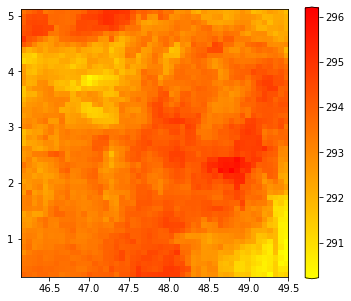

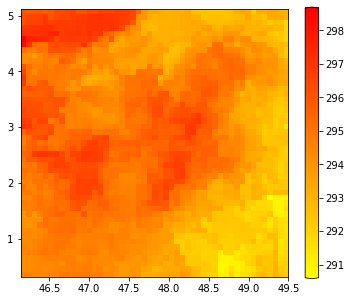

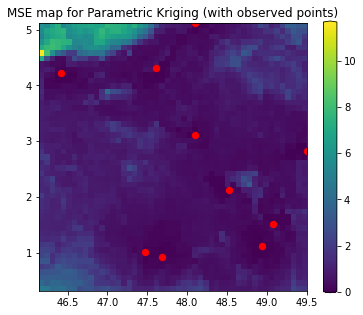

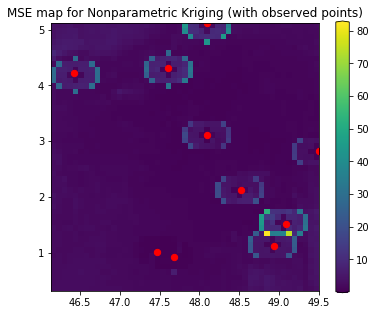

Parametric
Mean MSE:  1.073017111852937
Standard Deviation MSE:  0.3354772730302491
NonParametric
Mean MSE:  2.94411367803218
Standard Deviation MSE:  1.9308697507116568


In [35]:
# TRAINING DATA

field_train = creation_random_field(N, lignes, "20050601")

points_train, X_train = creation_training_dataset(n, points_S, field_train, step)

# TESTING DATA

field_test = creation_random_field(N, lignes, "20050602")

seed_test_obs = 234
points_test, X_test = creation_testing_dataset(d, points_S, field_test, seed_test_obs)

# AFFICHAGE

point_min_x = points_S[:, 0].min()
point_max_x = points_S[:, 0].max()
point_min_y = points_S[:, 1].min()
point_max_y = points_S[:, 1].max()

bounds_extent = [point_min_x, point_max_x, point_min_y, point_max_y]

# Training

field_train_aff = affichage_field(points_S, field_train, points_train, 0, True)

# Testing

field_test_aff = affichage_field(points_S, field_test, points_test, 1, True)



# EXPERIENCES

n_exp = 92

mois = "06"
jour = 0

list_parametric_kriging = list()
list_parametric_MSE = list()
list_nonparametric_kriging = list()
list_nonparametric_MSE = list()

H_n_1 = list_distance(points_train)
H_n_tri = H_n_1.copy()
H_n_tri.sort()

for exp in range(n_exp):
    
    if exp%25 == 0:
            print("exp nb: ", exp)
    
    
    jour += 1
    if exp == 30:
        mois = "07"
        jour = 1
    elif exp == 61:
        mois = "08"
        jour = 1
    
    if jour < 10:
        jour_str = "0" + str(jour)
    else:
        jour_str = str(jour)
    date_train = "2004" + mois + jour_str
    date_test = "2005" + mois + jour_str
    
    
    # TRAINING DATA
    field_train = creation_random_field(N, lignes, date_train)
    points_train, X_train = creation_training_dataset(n, points_S, field_train, step)

    # TESTING DATA
    field_test = creation_random_field(N, lignes, date_test)
    seed_test_obs = 234
    points_test, X_test = creation_testing_dataset(d, points_S, field_test, seed_test_obs)

    # Training
    field_train_aff = affichage_field(points_S, field_train, points_train, 0, False)

    # Testing
    field_test_aff = affichage_field(points_S, field_test, points_test, 1, False)

    # PARAMETRIC KRIGING
    X_par_kri = parametric_kriging_field(X_test, points_S, Nx, points_test, theta, cov_type)
    MSE_par_kri = np.sum( (X_par_kri - field_test_aff)**2 /N )
    par_quad_diff = (field_test_aff - X_par_kri)**2
    if exp == 0:
        print(MSE_par_kri)
        plotting_field(X_par_kri, points_test, bounds_extent, [0, 0])
        plotting_field(par_quad_diff, points_test, bounds_extent, [1, 0])
        
    # NONPARAMETRIC KRIGING
    List_covariances_Hn_tri = construct_list_covariances(H_n_tri, X_train, points_train, nu)
    X_nonpar_kri = nonparametric_kriging_field(X_test, points_S, Nx, List_covariances_Hn_tri, points_test, H_n_tri, reg)
    MSE_nonpar_kri = np.sum( (X_nonpar_kri - field_test_aff)**2 /N )
    nonpar_quad_diff = (field_test_aff - X_nonpar_kri)**2
    if exp == 0:
        print(MSE_nonpar_kri)
        plotting_field(X_nonpar_kri, points_test, bounds_extent, [0, 1])
        plotting_field(nonpar_quad_diff, points_test, bounds_extent, [1, 1])
    
    list_parametric_kriging.append(par_quad_diff)
    list_parametric_MSE.append(MSE_par_kri)
    list_nonparametric_kriging.append(nonpar_quad_diff)
    list_nonparametric_MSE.append(MSE_nonpar_kri)

    
array_parametric_kriging = np.array(list_parametric_kriging)
array_parametric_MSE = np.array(list_parametric_MSE)
array_nonparametric_kriging = np.array(list_nonparametric_kriging)
array_nonparametric_MSE = np.array(list_nonparametric_MSE)
    
Quad_Diff_MEAN_par = array_parametric_kriging.mean(axis = 0)
plotting_field(Quad_Diff_MEAN_par, points_test, bounds_extent, params = [2, 0])
    
Quad_Diff_MEAN_nonpar = array_nonparametric_kriging.mean(axis = 0)
plotting_field(Quad_Diff_MEAN_nonpar, points_test, bounds_extent, params = [2, 1])
    
print("Parametric")
print("Mean MSE: ", array_parametric_MSE.mean())
print("Standard Deviation MSE: ", array_parametric_MSE.std())
    
print("NonParametric")
print("Mean MSE: ", array_nonparametric_MSE.mean())
print("Standard Deviation MSE: ", array_nonparametric_MSE.std())